In [2]:
from blendshape_info import BLENDSHAPE_MODEL_LANDMARKS_SUBSET, BLENDSHAPE_NAMES, parse_prototxt

2024-03-18 15:02:17.367048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 15:02:17.390656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 15:02:17.766112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


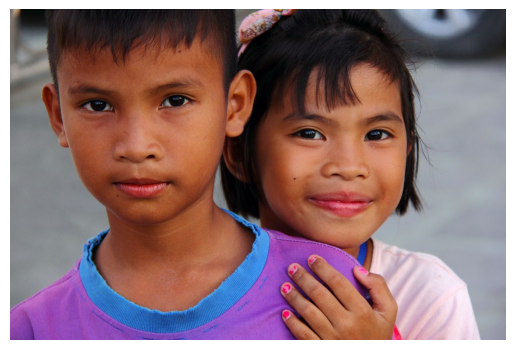

In [2]:
import cv2
import pylab as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


IMAGE_FILE = 'image.jpg'


def cv2_imshow(img):
    plt.imshow(img[..., ::-1])
    plt.axis('off')
    plt.show()

img = cv2.imread(IMAGE_FILE)
cv2_imshow(img)
image_mp = mp.Image.create_from_file(IMAGE_FILE)

In [29]:
def init_mpipe_blendshapes_model():
    base_options = python.BaseOptions(
        model_asset_path="face_landmarker_v2_with_blendshapes.task",
        # delegate=mp.tasks.BaseOptions.Delegate.GPU,
        delegate=mp.tasks.BaseOptions.Delegate.CPU,
    )
    mp_mode = mp.tasks.vision.FaceDetectorOptions.running_mode.IMAGE
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        running_mode=mp_mode,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=2,
        # result_callback=self.result_callback,
    )
    return vision.FaceLandmarker.create_from_options(options)


mesh_detector = init_mpipe_blendshapes_model()
mesh_results = mesh_detector.detect(image_mp)

I0000 00:00:1710742074.031086  287241 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1710742074.055879  287637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 530.30.02), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1710742074.056191  287241 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [126]:
# Predicted with the tflite model instead of ONNX, but it seems results are identical so that can't be the issue
import tensorflow as tf
import numpy as np
import cv2


class TFLiteModel:
    def __init__(self, model_path: str):
        self.interpreter = tf.lite.Interpreter(model_path)
        self.interpreter.allocate_tensors()

        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def predict(self, *data_args):
        assert len(data_args) == len(self.input_details)
        for data, details in zip(data_args, self.input_details):
            self.interpreter.set_tensor(details["index"], data)
        self.interpreter.invoke()
        return self.interpreter.get_tensor(self.output_details[0]["index"])


tflite_model = TFLiteModel("face_blendshapes.tflite")
label = tflite_model.predict(landmarks_np[:1, np.array(BLENDSHAPE_MODEL_LANDMARKS_SUBSET), :2])
# label

In [145]:
import numpy as np
import onnxruntime as rt

def print_top(p):
    assert len(p.reshape(-1)) == len(BLENDSHAPE_NAMES)
    print([BLENDSHAPE_NAMES[i] for i in (-p.reshape(-1)).argsort()[:5]])
def get_blendshape_score_by_index(blendshapes, i):
    return [_ for _ in blendshapes if _.index == i][0].score
def predict_with_onnx(x):
    onnx_path = './face_blendshapes.onnx'
    input_names, output_names = (['serving_default_input_points:0'], ['StatefulPartitionedCall:0'])
    providers = ['CPUExecutionProvider']
    m = rt.InferenceSession(onnx_path, providers=providers)
    onnx_pred = m.run(output_names, {input_names[0]: x})
    return onnx_pred[0]
def plot_and_compare_two(a, b):
    assert a.reshape(-1).shape[0] == 52
    assert b.reshape(-1).shape[0] == 52
    plt.figure(figsize=(10, 12))
    plt.barh(range(52), a.reshape(-1), alpha=0.5)#, label='a')
    # print_top(blendshapes_np[0])
    plt.barh(range(52), b.reshape(-1), alpha=0.5)#, label='b')
    # print_top(onnx_pred[0])
    plt.yticks(range(len(BLENDSHAPE_NAMES)), BLENDSHAPE_NAMES, rotation=0)
    # plt.legend()
    plt.show()


landmarks_np = []
for face_idx in range(len(mesh_results.face_landmarks)):
    # landmarks_np.append(np.array([[i.y, i.x] for i in mesh_results.face_landmarks[face_idx]]))
    landmarks_np.append(np.array([[i.x, i.y, i.z] for i in mesh_results.face_landmarks[face_idx]]))
landmarks_np = np.array(landmarks_np).astype('float32')
landmarks_np.shape
blendshapes_np = np.array([[get_blendshape_score_by_index(mesh_results.face_blendshapes[face_idx], i) for i in range(52)] for face_idx in range(len(mesh_results.face_landmarks))])
blendshapes_np.shape

(2, 52)

In [162]:
path = 'face_blendshapes_in_landmarks.prototxt'
test_lmks_in = parse_prototxt(path)[:, :2]
path = 'face_blendshapes_out.prototxt'
test_blshps_out = parse_prototxt(path)

In [205]:
# # s = np.array([image_mp.width, image_mp.height])[None, None].astype('float32')
# s = np.array([1.0, 0.8])[None, None].astype('float32')
# a = (1 - s) / 2
# print(a)

# plot_and_compare_two(
#     predict_with_onnx(test_lmks_in[None, np.array(BLENDSHAPE_MODEL_LANDMARKS_SUBSET)] / s),
#     test_blshps_out,
# )

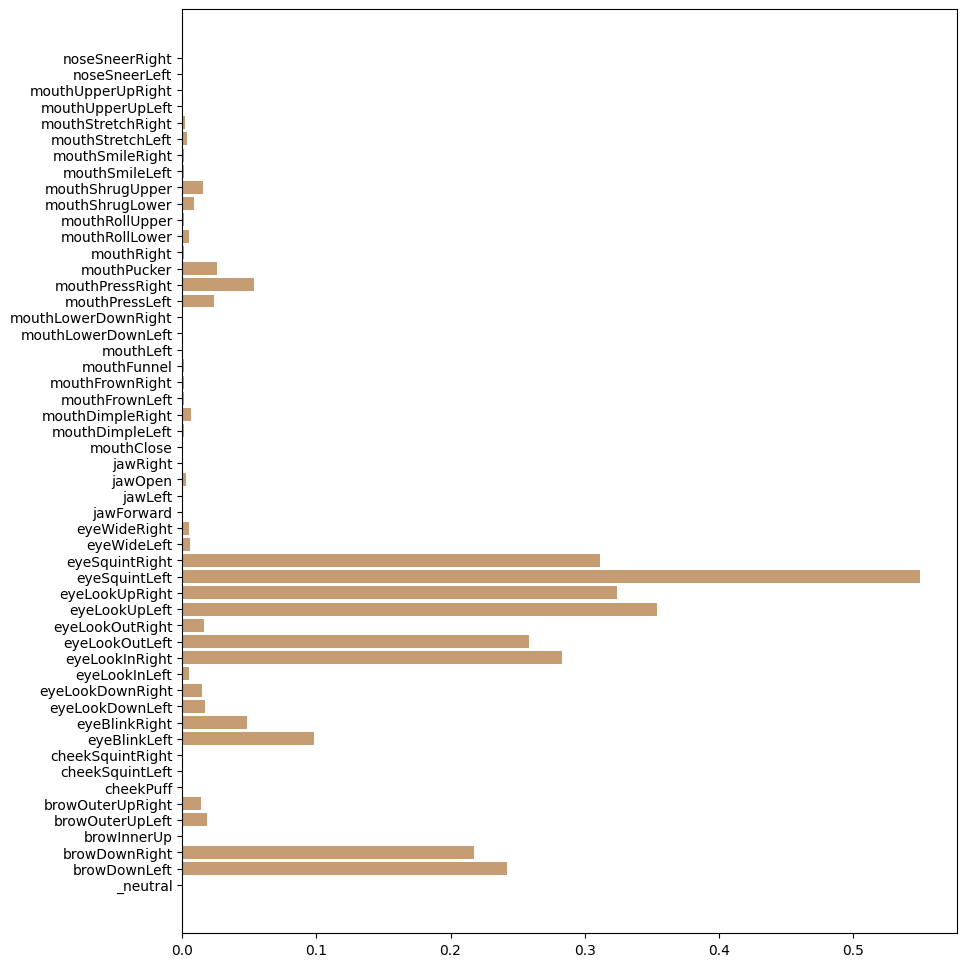

In [204]:
x = landmarks_np[:1, np.array(BLENDSHAPE_MODEL_LANDMARKS_SUBSET), :2] #* 0 + 0.01
s = np.array([image_mp.width, image_mp.height])[None, None].astype('float32')
onnx_pred = predict_with_onnx(x * s)
plot_and_compare_two(blendshapes_np[0], onnx_pred)
# print('ONNX Predicted:', onnx_pred[0])